# Feature Engineering

In their raw form, features are often a poor fit for Machine Learning usage. Often times, you have to scale them down or manufacture new features based on original features in order to attain a useful data set.

Here, I give a brief and basic example of such a task.

1. Load the data into DataFrame
2. Scale the data using StandardScaler
3. Create some new features
4. Look to see if any features have discriminating power
5. Check that new features are time-invariant

## 1. Load the data into a DataFrame

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white")
sns.set_context("paper", font_scale=1.4)

In [2]:
df = pd.read_csv('raw-data.csv', index_col='eventID')
df.head()

,AfterInhMATRIX5,PrescaleMATRIX5,RawMATRIX4,RawTriggers,label
eventID,,,,,
430001,27094,12,1598521,10759045,2
430002,34901,14,1670878,11813291,3
430003,36317,15,1675869,12002554,3
430004,34088,14,1637602,11564482,3
430005,27489,12,1587623,10627391,4


In [3]:
intensity_df = pd.read_csv('intensity.csv', sep='\t', index_col='eventID')
intensity_df.head()

,intensity
eventID,
435610,1.127966
435611,1.131964
435612,1.110465
435616,1.133347
435617,1.143530


### Scale these features to the "intensity" data...

... by dividing each feature by the intensity value for that eventID.

I know, from my domain expertise, that these features are highly correlated
with intensity, but the intensity itself<br>
is independent of label. So, to help tone down fluctuations due to intensity,
I divide all the features by this <br>intensity from our experiment.

Note that Pandas uses the eventID indexes from both dataframes in order to line
the values up for easy division.

In [5]:
adj_df = df.copy()
for column in adj_df.columns[:-1]:
    adj_df[column] = adj_df[column] / intensity_df['intensity']
adj_df.head()

,AfterInhMATRIX5,PrescaleMATRIX5,RawMATRIX4,RawTriggers,label
eventID,,,,,
430001,26971.133159,11.945582,1591271.969755,10710254.497648,2
430002,34303.959124,13.760506,1642294.794229,11611204.595436,3
430003,35256.575493,14.562013,1626935.096911,11652089.963578,3
430004,33680.502926,13.832640,1618025.667488,11426237.087646,3
430005,26924.927301,11.753761,1555045.067351,10409317.547906,4


In [6]:
# Same exact thing, but using `apply()` instead of looping
adj_df = df.copy()
adj_df[adj_df.columns[:-1]] = \
    adj_df[adj_df.columns[:-1]].apply(lambda x: x / intensity_df['intensity'])
adj_df.head()

,AfterInhMATRIX5,PrescaleMATRIX5,RawMATRIX4,RawTriggers,label
eventID,,,,,
430001,26971.133159,11.945582,1591271.969755,10710254.497648,2
430002,34303.959124,13.760506,1642294.794229,11611204.595436,3
430003,35256.575493,14.562013,1626935.096911,11652089.963578,3
430004,33680.502926,13.832640,1618025.667488,11426237.087646,3
430005,26924.927301,11.753761,1555045.067351,10409317.547906,4


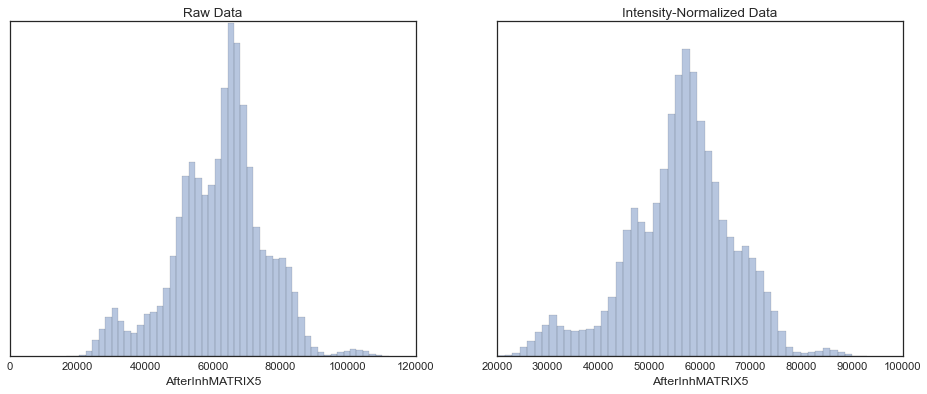

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
sns.distplot(df.AfterInhMATRIX5, kde=False, ax=ax1)
sns.distplot(adj_df.AfterInhMATRIX5, kde=False, ax=ax2)
ax1.set_title("Raw Data")
ax2.set_title("Intensity-Normalized Data")
ax1.set_yticklabels('', visible=False)
ax2.set_yticklabels('', visible=False)
plt.show()

## 2. Scale the data using StandardScaler and RobustScaler

In [8]:
# Very standard and useful tool for scaling features
from sklearn.preprocessing import StandardScaler

# Make a copy of the data
std_df = adj_df.copy()

# Fit the scaling factors and save the scale
std_scale = StandardScaler().fit(std_df[std_df.columns[:-1]])
# Apply the StandardScaler transformation to the data
std_df[std_df.columns[:-1]] = \
    std_scale.transform(std_df[std_df.columns[:-1]])

In [9]:
# A newer tool that's robust against outliers
from sklearn.preprocessing import RobustScaler

# Make a copy of the data
robust_df = adj_df.copy()

# Fit the scaling factors and save the scale
robust_scale = RobustScaler().fit(robust_df[robust_df.columns[:-1]])
# Apply the StandardScaler transformation to the data
robust_df[robust_df.columns[:-1]] = \
    robust_scale.transform(robust_df[robust_df.columns[:-1]])

### Note the new distribution

StandardScaler scales everything down such that:

* the mean is zero
* the standard deviation is unity

RobustScaler, on the other hand:

* the mean is zero
* scales the data according to the IQR (inner-quartile range)

RobustScaler is less likely to "squish" your primary set of samples because of a couple very large or small outliers. The std dev is not exactly 1 as a result, but that's okay!

In [12]:
std_df.describe().ix[['mean', 'std']]

,AfterInhMATRIX5,PrescaleMATRIX5,RawMATRIX4,RawTriggers,label
mean,1.036857e-15,-1.170201e-15,9.852638e-16,-3.884148e-15,2.644401
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.866411


In [13]:
robust_df.describe().ix[['mean', 'std']]

,AfterInhMATRIX5,PrescaleMATRIX5,RawMATRIX4,RawTriggers,label
mean,-0.059579,-0.059412,0.319332,0.125746,2.644401
std,0.851891,0.843980,0.877232,0.893102,1.866411


### To get a good visual, plot it

See that everything is just scaled down and shifted. The distribution is intact.

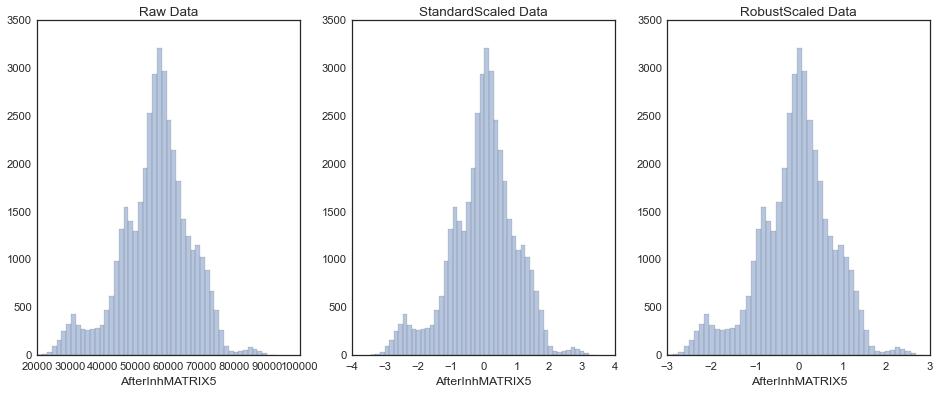

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6))
sns.distplot(adj_df.AfterInhMATRIX5, kde=False, ax=ax1)
sns.distplot(std_df.AfterInhMATRIX5, kde=False, ax=ax2)
sns.distplot(robust_df.AfterInhMATRIX5, kde=False, ax=ax3)
ax1.set_title("Raw Data")
ax2.set_title("StandardScaled Data")
ax3.set_title("RobustScaled Data")
plt.show()

### Rename for ease of use

Now that we've robbed them of their real values, let's strip them of their real names.

In [15]:
scaled_df = robust_df.copy()
scaled_df.columns = ['f1', 'f2', 'f3', 'f4', 'label']
scaled_df.head()

,f1,f2,f3,f4,label
eventID,,,,,
430001,-2.426485,-2.231888,-0.648100,-0.288266,2
430002,-1.833241,-1.886232,-0.557255,0.956998,3
430003,-1.756172,-1.733583,-0.584603,1.013509,3
430004,-1.883680,-1.872494,-0.600466,0.701342,3
430005,-2.430223,-2.268421,-0.712601,-0.704211,4


## 3. Create some new features

1. The difference between two or more features
2. One feature scaled by another

In [67]:
# Define a helper function for adding new features based on two fields
# and a binary operator
def add_new_feature(df, feature1, feature2, operator, name):
    """Arguments: 
           `df`: a Pandas DataFrame
           `feature1`, `feature2`: string of two feature names
           `operator`: a function that takes two Pandas Series as operands
           `name`: name of column to insert with the calculated new feature
       Returns:
           The original DataFrame with this new feature inserted"""
    if name in df.columns:
        df = df.drop(name, axis=1)
    df.insert(len(df.columns)-1, name, None)
    df[name] = operator(df[feature1], df[feature2])
    return df

In [17]:
scaled_df = add_new_feature(scaled_df, 'f2', 'f1', np.subtract, 'f2-f1')
scaled_df = add_new_feature(scaled_df, 'f3', 'f1', np.subtract, 'f3-f1')
scaled_df = add_new_feature(scaled_df, 'f4', 'f1', np.subtract, 'f4-f1')
scaled_df = add_new_feature(scaled_df, 'f3', 'f2', np.subtract, 'f3-f2')
scaled_df = add_new_feature(scaled_df, 'f4', 'f2', np.subtract, 'f4-f2')
scaled_df = add_new_feature(scaled_df, 'f4', 'f3', np.subtract, 'f4-f3')
scaled_df.head()

,f1,f2,f3,f4,f2-f1,f3-f1,f4-f1,f3-f2,f4-f2,f4-f3,label
eventID,,,,,,,,,,,
430001,-2.426485,-2.231888,-0.648100,-0.288266,0.194597,1.778385,2.138219,1.583788,1.943622,0.359834,2
430002,-1.833241,-1.886232,-0.557255,0.956998,-0.052991,1.275986,2.790239,1.328977,2.843230,1.514253,3
430003,-1.756172,-1.733583,-0.584603,1.013509,0.022589,1.171569,2.769680,1.148980,2.747092,1.598111,3
430004,-1.883680,-1.872494,-0.600466,0.701342,0.011186,1.283214,2.585022,1.272028,2.573836,1.301808,3
430005,-2.430223,-2.268421,-0.712601,-0.704211,0.161802,1.717622,1.726012,1.555819,1.564210,0.008390,4


In [18]:
scaled_df = add_new_feature(scaled_df, 'f2', 'f1', np.multiply, 'f2*f1')
scaled_df = add_new_feature(scaled_df, 'f3', 'f1', np.multiply, 'f3*f1')
scaled_df = add_new_feature(scaled_df, 'f4', 'f1', np.multiply, 'f4*f1')
scaled_df = add_new_feature(scaled_df, 'f3', 'f2', np.multiply, 'f3*f2')
scaled_df = add_new_feature(scaled_df, 'f4', 'f2', np.multiply, 'f4*f2')
scaled_df = add_new_feature(scaled_df, 'f4', 'f3', np.multiply, 'f4*f3')
scaled_df.head()

,f1,f2,f3,f4,f2-f1,f3-f1,f4-f1,f3-f2,f4-f2,f4-f3,f2*f1,f3*f1,f4*f1,f3*f2,f4*f2,f4*f3,label
eventID,,,,,,,,,,,,,,,,,
430001,-2.426485,-2.231888,-0.648100,-0.288266,0.194597,1.778385,2.138219,1.583788,1.943622,0.359834,5.415644,1.572606,0.699473,1.446487,0.643377,0.186825,2
430002,-1.833241,-1.886232,-0.557255,0.956998,-0.052991,1.275986,2.790239,1.328977,2.843230,1.514253,3.457917,1.021583,-1.754408,1.051112,-1.805120,-0.533292,3
430003,-1.756172,-1.733583,-0.584603,1.013509,0.022589,1.171569,2.769680,1.148980,2.747092,1.598111,3.044470,1.026663,-1.779895,1.013457,-1.757001,-0.592500,3
430004,-1.883680,-1.872494,-0.600466,0.701342,0.011186,1.283214,2.585022,1.272028,2.573836,1.301808,3.527179,1.131086,-1.321104,1.124368,-1.313259,-0.421132,3
430005,-2.430223,-2.268421,-0.712601,-0.704211,0.161802,1.717622,1.726012,1.555819,1.564210,0.008390,5.512770,1.731781,1.711390,1.616480,1.597447,0.501822,4


In [68]:
# Make up your own function if you'd like
def my_func(s1, s2):
    # (s1 - s2)^2
    print s1.head()
    print s2.head()
    print ((s1 - s2)**2).head()
    return (s1 - s2)**2

In [69]:
scaled_df = add_new_feature(scaled_df, 'f2', 'f1', my_func, 'f(f2,f1)')
scaled_df = add_new_feature(scaled_df, 'f3', 'f1', my_func, 'f(f3,f1)')
scaled_df = add_new_feature(scaled_df, 'f4', 'f1', my_func, 'f(f4,f1)')
scaled_df = add_new_feature(scaled_df, 'f3', 'f2', my_func, 'f(f3,f2)')
scaled_df = add_new_feature(scaled_df, 'f4', 'f2', my_func, 'f(f4,f2)')
scaled_df = add_new_feature(scaled_df, 'f4', 'f3', my_func, 'f(f4,f3)')

eventID
430001   -2.231888
430002   -1.886232
430003   -1.733583
430004   -1.872494
430005   -2.268421
Name: f2, dtype: float64
eventID
430001   -2.426485
430002   -1.833241
430003   -1.756172
430004   -1.883680
430005   -2.430223
Name: f1, dtype: float64
eventID
430001    0.037868
430002    0.002808
430003    0.000510
430004    0.000125
430005    0.026180
dtype: float64
eventID
430001   -0.648100
430002   -0.557255
430003   -0.584603
430004   -0.600466
430005   -0.712601
Name: f3, dtype: float64
eventID
430001   -2.426485
430002   -1.833241
430003   -1.756172
430004   -1.883680
430005   -2.430223
Name: f1, dtype: float64
eventID
430001    3.162653
430002    1.628140
430003    1.372574
430004    1.646639
430005    2.950225
dtype: float64
eventID
430001   -0.288266
430002    0.956998
430003    1.013509
430004    0.701342
430005   -0.704211
Name: f4, dtype: float64
eventID
430001   -2.426485
430002   -1.833241
430003   -1.756172
430004   -1.883680
430005   -2.430223
Name: f1, dtype: floa

In [55]:
scaled_df.head()

,f1,f2,f3,f4,f2-f1,f3-f1,f4-f1,f3-f2,f4-f2,f4-f3,...,"f2(f3,f2)","f2(f4,f2)","f2(f4,f3)","f(f2,f1)","f(f3,f1)","f(f4,f1)","f(f3,f2)","f(f4,f2)","f(f4,f3)",label
eventID,,,,,,,,,,,,,,,,,,,,,
430001,-2.426485,-2.231888,-0.648100,-0.288266,0.194597,1.778385,2.138219,1.583788,1.943622,0.359834,...,13.247223,18.984491,3.895548,0.037868,3.162653,4.571983,2.508384,3.777668,0.129481,2
430002,-1.833241,-1.886232,-0.557255,0.956998,-0.052991,1.275986,2.790239,1.328977,2.843230,1.514253,...,10.267429,46.675989,12.357377,0.002808,1.628140,7.785434,1.766179,8.083956,2.292963,3
430003,-1.756172,-1.733583,-0.584603,1.013509,0.022589,1.171569,2.769680,1.148980,2.747092,1.598111,...,8.576108,42.397589,13.438333,0.000510,1.372574,7.671129,1.320156,7.546512,2.553960,3
430004,-1.883680,-1.872494,-0.600466,0.701342,0.011186,1.283214,2.585022,1.272028,2.573836,1.301808,...,9.699049,35.653087,9.992231,0.000125,1.646639,6.682340,1.618055,6.624630,1.694704,3
430005,-2.430223,-2.268421,-0.712601,-0.704211,0.161802,1.717622,1.726012,1.555819,1.564210,0.008390,...,12.881852,12.990391,2.741185,0.026180,2.950225,2.979119,2.420574,2.446753,0.000070,4


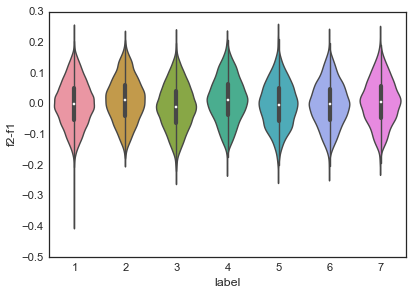

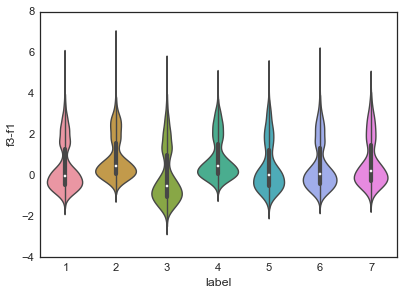

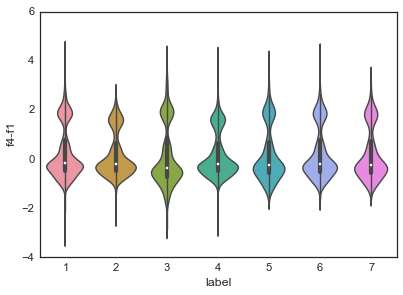

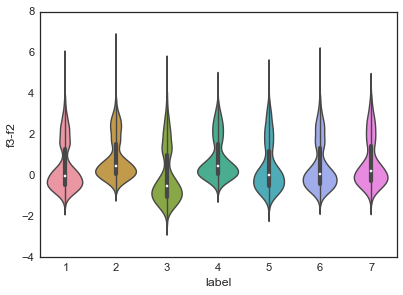

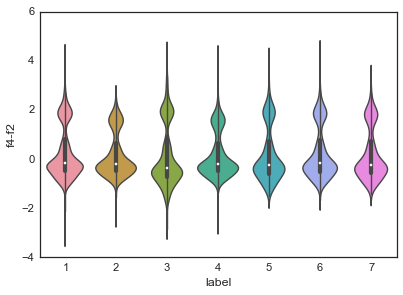

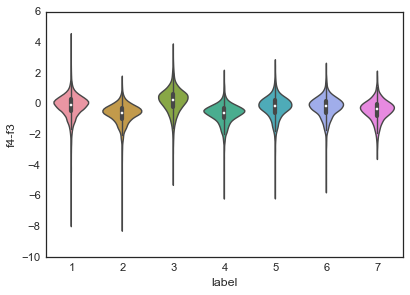

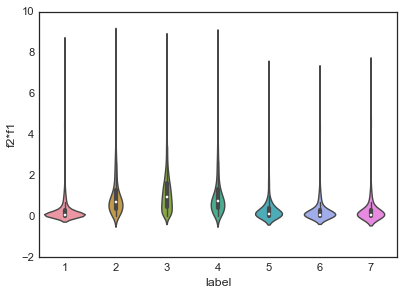

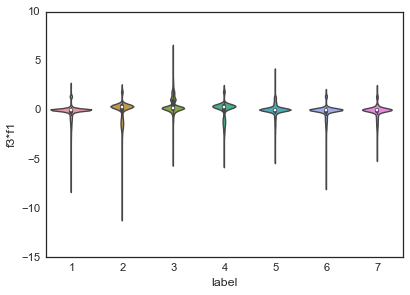

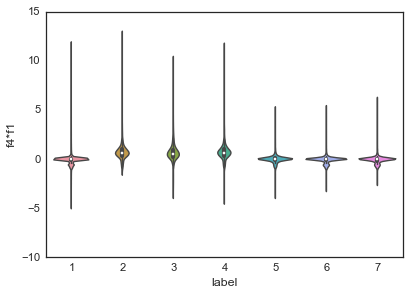

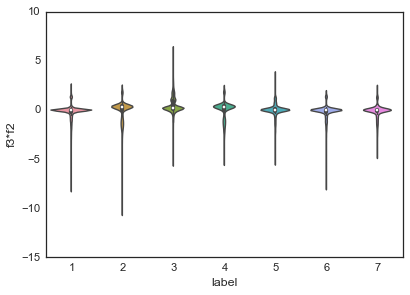

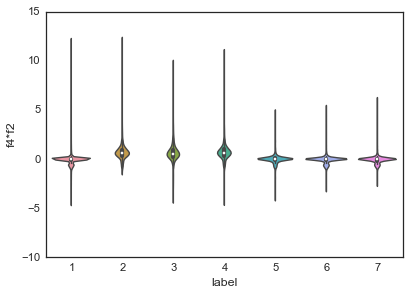

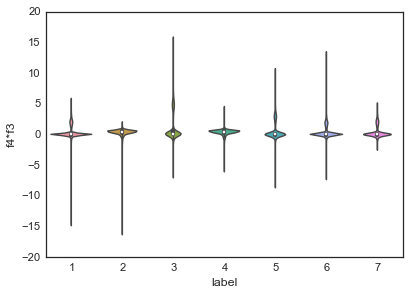

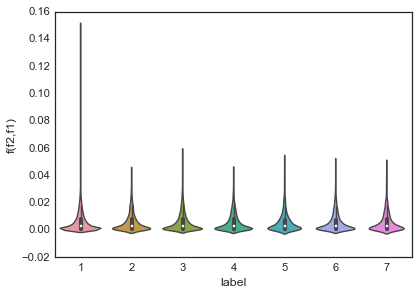

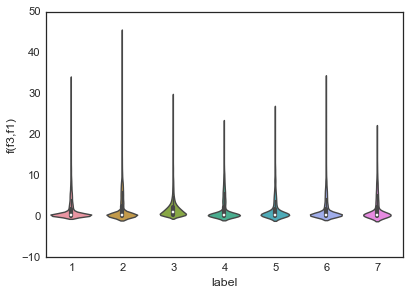

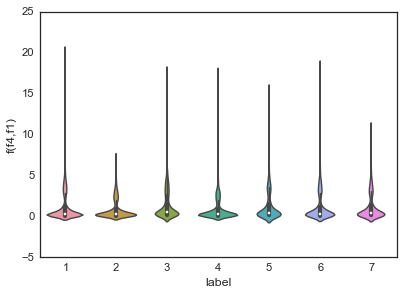

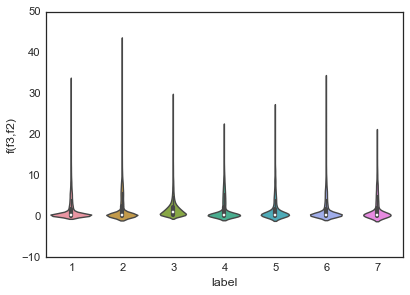

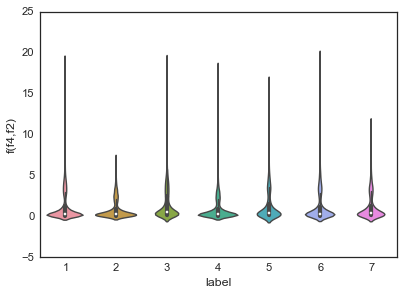

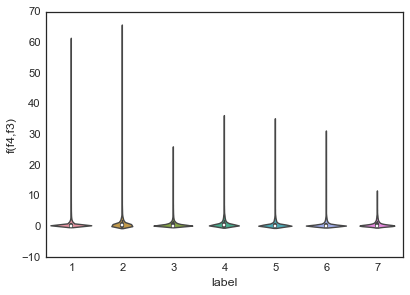

In [56]:
for feature in ['f2-f1', 'f3-f1', 'f4-f1', 'f3-f2', 'f4-f2', 'f4-f3', 
                'f2*f1', 'f3*f1', 'f4*f1', 'f3*f2', 'f4*f2', 'f4*f3']:
    sns.violinplot(x='label', y=feature, data=scaled_df.sort_values('label'))
    plt.show()

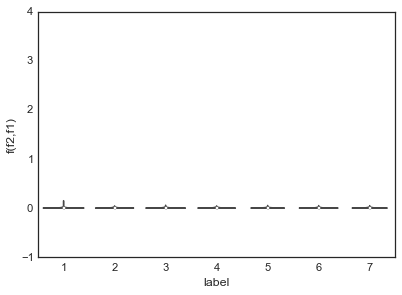

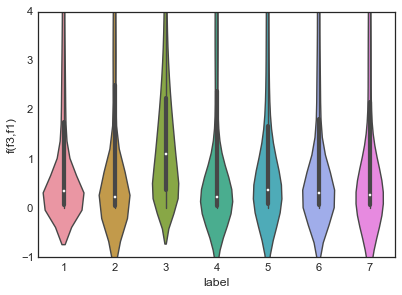

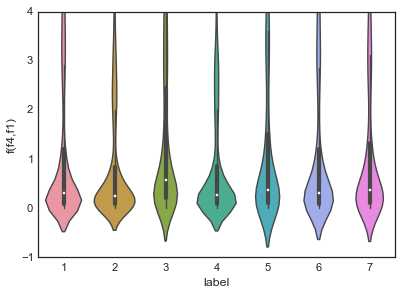

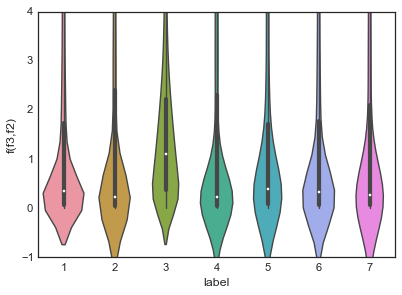

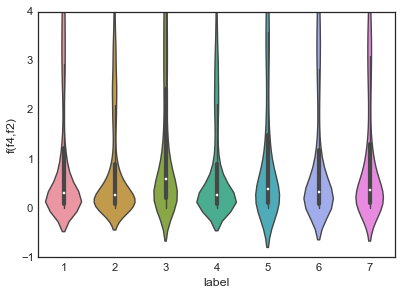

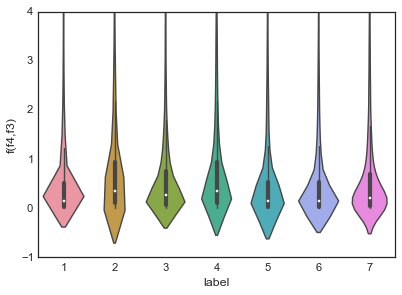

In [64]:
for feature in ['f(f2,f1)', 'f(f3,f1)', 'f(f4,f1)', 'f(f3,f2)', 'f(f4,f2)', 'f(f4,f3)']:
    sns.violinplot(x='label', y=feature, data=scaled_df.sort_values('label'))
    plt.ylim([-1,4])
    plt.show()

In [36]:
#sns.violinplot(x='label', y="e(f4,f3)", data=scaled_df.sort_values('label'))
scaled_df.sort_values('label').columns

Index([u'f1', u'f2', u'f3', u'f4', u'f2-f1', u'f3-f1', u'f4-f1', u'f3-f2',
       u'f4-f2', u'f4-f3', u'f2*f1', u'f3*f1', u'f4*f1', u'f3*f2', u'f4*f2',
       u'f4*f3', u'e(f2,f1)', u'e(f3,f1)', u'e(f4,f1)', u'e(f3,f2)',
       u'e(f4,f2)', u'e(f4.f3)', u'label'],
      dtype='object')